# Contrast Evaluation

This notebook provides the code for the contrast evaluation on a PICMUS real world data-set by evaluating the Contrast-to-Noise ratio of two anechoic regions.

The notebook is layed out in a way that two beamformers are applied to the same data and evaluated using the same metrics. It is recommended to leave the first beamformer as a DAS beamformer to have a baseline and use the beamformer class one wants to scrutinize as the second one.

In [1]:
"""
   Copyright (C) 2021 ETH Zurich. All rights reserved.

   Author: Wolfgang Boettcher, ETH Zurich

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
"""

import os
from os.path import abspath
from os.path import dirname as up
import numpy as np
import sys

%matplotlib notebook


In [2]:
# Insert path to pybf library to system path
# path_to_lib ='/home/vsergei/Projects/repos'
# print(path_to_lib)
# sys.path.insert(0, path_to_lib)


In [3]:
# path_to_lib = os.path.abspath("__file__")
path_to_lib = up(up(up(up(up(os.path.abspath("__file__"))))))
sys.path.insert(0, path_to_lib)
# os.path.dirname(os.path.abspath("__file__"))
from pybf.pybf.io_interfaces import DataLoader
from pybf.scripts.beamformer_DAS_ref import BFCartesianReference
from pybf.scripts.beamformer_mvbf_spatial_smooth import BFMVBFspatial
from pybf.scripts.beamformer_mvbf_DCR import BFMVBFdcr
from pybf.pybf.image_settings import ImageSettings
from pybf.pybf.visualization import plot_image
from pybf.scripts.picmus_eval import PicmusEval



In [4]:
dataset_path_contrast = path_to_lib + '/pybf/tests/data/Picmus/contrast_speckle/rf_dataset.hdf5'

In [5]:
data_loader_obj_contrast = DataLoader(dataset_path_contrast)

 ### Image settings

For some beamformers evaluated in the project, the tx_strategy needs to be set up in a way that at least two plane waves need to be emitted from different angles.

In [6]:
### Specify Image settings and create corresponding object ###

img_res = [400, 600]
image_x_range = [-0.019, 0.019]
image_z_range = [0.005, 0.05]

db_range = 50

LATERAL_PIXEL_DENSITY_DEFAULT = 5

img_config = ImageSettings(image_x_range[0],
                           image_x_range[1],
                           image_z_range[0],
                           image_z_range[1],
                           LATERAL_PIXEL_DENSITY_DEFAULT,
                           data_loader_obj_contrast.transducer)

### Specify preprocessing parameters for RF data ###

decimation_factor = 1
interpolation_factor = 10

### Specify TX strategy and Apodization parameters ###

start_time = 0
correction_time_shift = 0

alpha_fov_apod = 40

# 1 Plane waves with inclination angle 0
# tx_strategy = ['PW_75_16', [16]]
tx_strategy = ['PW_4_2.1', [data_loader_obj_contrast.tx_strategy[1][33], data_loader_obj_contrast.tx_strategy[1][37], data_loader_obj_contrast.tx_strategy[1][38], data_loader_obj_contrast.tx_strategy[1][42]]]
rf_data_shape = (len(tx_strategy[1]),) + data_loader_obj_contrast.get_rf_data(0, 0).shape
rf_data = np.zeros(rf_data_shape)
inclin_index = np.asarray([33, 37, 38, 42])
for i in range(rf_data.shape[0]):
    rf_data[i, :, :] = data_loader_obj_contrast.get_rf_data(0, inclin_index[i])

### Specify Sampling Frequency ###

SAMPLING_FREQ = 20.832 * (10 ** 6)

filters_params = [1 * 10 **6, 8 * 10 **6, 0.5 * 10 **6]


The highest resolution for the system is:  (633, 205)


 ## Instantiate beamformers

In [7]:
bf = BFCartesianReference(data_loader_obj_contrast.f_sampling,
                         tx_strategy,
                         data_loader_obj_contrast.transducer,
                         decimation_factor,
                         interpolation_factor,
                         img_res,
                         img_config,
                         start_time=start_time,
                         correction_time_shift=correction_time_shift,
                         alpha_fov_apod=alpha_fov_apod,
                         bp_filter_params=filters_params,
                         envelope_detector='I_Q',
                         picmus_dataset=True,
                         channel_reduction=32)                           # Enter number of active receive channels here
bf2 = BFMVBFdcr(data_loader_obj_contrast.f_sampling,
                         tx_strategy,
                         data_loader_obj_contrast.transducer,
                         decimation_factor,
                         interpolation_factor,
                         img_res,
                         img_config,
                         start_time=start_time,
                         correction_time_shift=correction_time_shift,
                         alpha_fov_apod=alpha_fov_apod,
                         bp_filter_params=filters_params,
                         envelope_detector='I_Q',
                         picmus_dataset=True,
                         channel_reduction=32,                           # Enter number of active receive channels here
                         window_width=16)                                # Enter width of sliding window here when using
                                                                         # spatial smoothing



Delays precalculation...
TX strategy: plane waves
Number of plane waves:  4
Maximum angle:  2.1 °
Apodization precalculation...
Delays precalculation...
TX strategy: plane waves
Number of plane waves:  4
Maximum angle:  2.1 °
Apodization precalculation...


## Beamform
 
Performs the beamforming for the whole image
 
 **Note:** This part of the code is by far the most computationally expensive step. Beamforming using a MVBF beamformer can take several minutes (up to approx. 20 minutes) if a high number of channels is used!

In [8]:
img_data = bf.beamform(rf_data, numba_active=True)
img_data2 = bf2.beamform(rf_data, numba_active=False)


Beamforming...
 
Time of execution: 12.795186281204224 seconds
Beamforming...
 
Time of execution: 85.75392866134644 seconds


## Evaluations

For both beamformers the Contrast-to-Noise ratio (CNR) metric is calculated for a number of predefined scatterers in the test data in dB.


### Eval DAS [b1]

BF Final dB range (-50.0,0.0)


/home/vsergei/Projects/repos/pybf/pybf/visualization.py:54: RuntimeWarning:

divide by zero encountered in log10



<IPython.core.display.Javascript object>


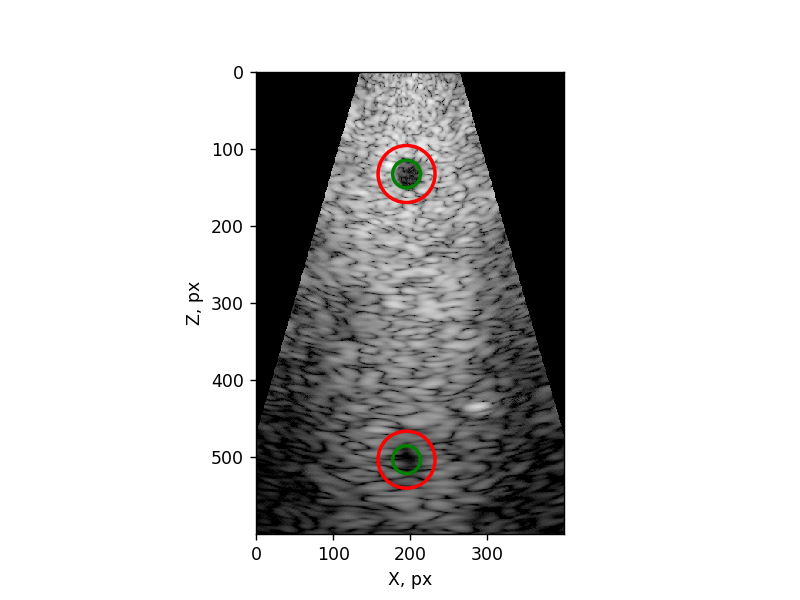

In [9]:
# Eval tests
eval_obj = PicmusEval(img_data, bf)
circle_pos = np.asarray([[-0.00043, 0.01492, 0.0035, 0.00172],
                            [-0.00043, 0.04279, 0.0035, 0.00172]])
CNR_values = eval_obj.evaluate_circ_contrast(circle_pos)

In [10]:
print("CNR values are [dB]:")
print(str(CNR_values) + "\n")

CNR values are [dB]:
[7.45803252 6.09532558]



### Eval MVBF [bf2]

BF Final dB range (-50.0,0.0)


<IPython.core.display.Javascript object>


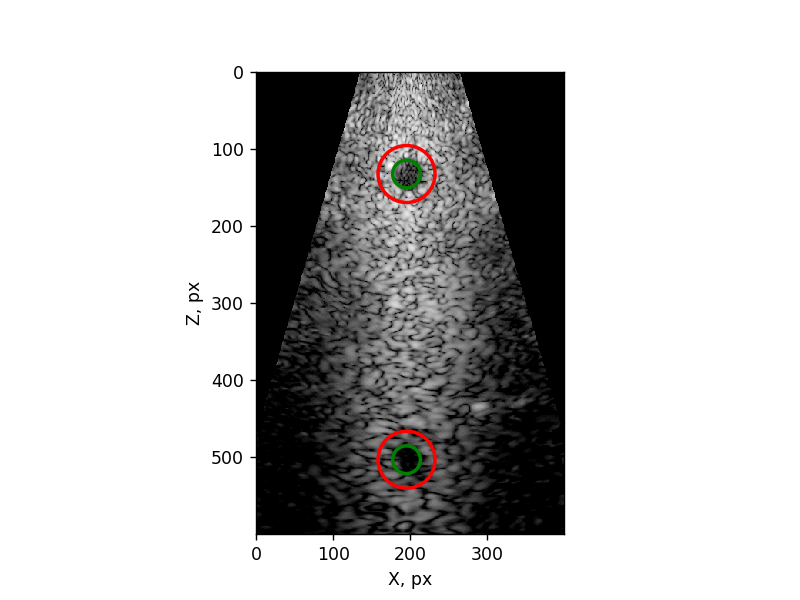

In [11]:
# Eval tests
eval_obj2 = PicmusEval(img_data2, bf)
CNR_values2 = eval_obj2.evaluate_circ_contrast(circle_pos)

In [12]:
print("CNR values are [dB]:")
print(str(CNR_values2) + "\n")

CNR values are [dB]:
[6.29527656 5.7193167 ]



 ### Visualize DAS [bf]

BF Final dB range (-50.0,0.0)


<IPython.core.display.Javascript object>


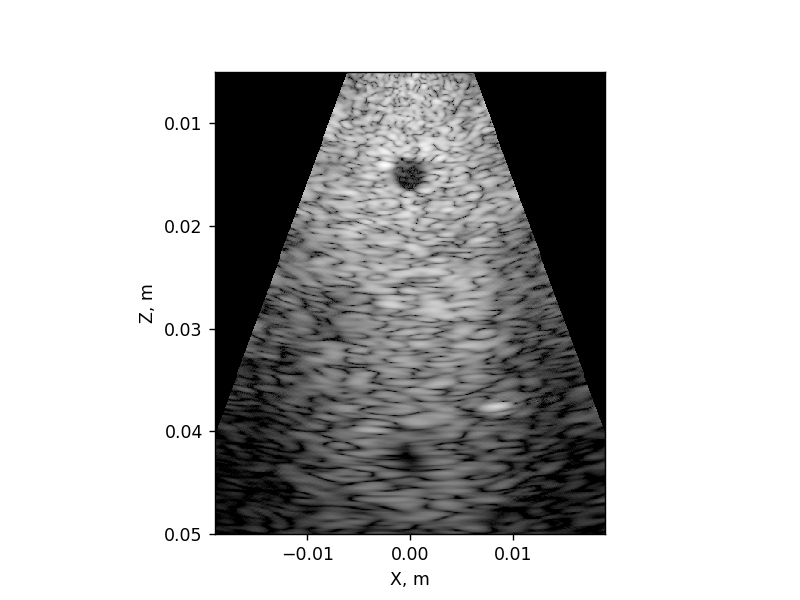

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc96d25dac8>)

In [13]:
plot_image(np.abs(img_data), 
               scatters_coords_xz=None,
               elements_coords_xz=None,
               framework='matplotlib',
               title='DAS_32_4',
               image_x_range=image_x_range,
               image_z_range=image_z_range,
               db_range=db_range,
               colorscale='Greys',
               save_fig=False, 
               show=True,
               path_to_save='.')


### Visualize MVBF [bf2]

BF Final dB range (-50.0,0.0)


<IPython.core.display.Javascript object>


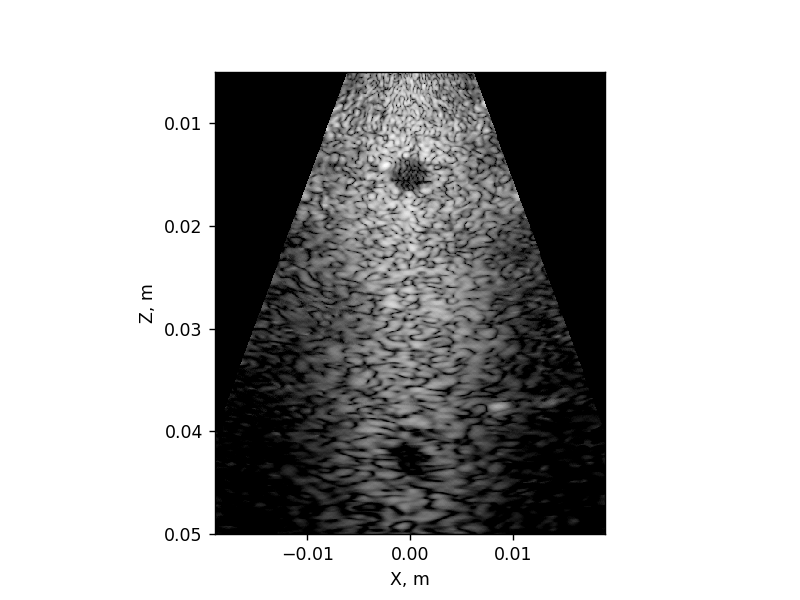

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc96d190550>)

In [14]:
plot_image(np.abs(img_data2), 
               scatters_coords_xz=None,
               elements_coords_xz=None,
               framework='matplotlib',
               title='MVBFdcr_32_4',
               image_x_range=image_x_range,
               image_z_range=image_z_range,
               db_range=db_range,
               colorscale='Greys',
               save_fig=False, 
               show=True,
               path_to_save='.')